Data saved to quadratic_data.csv.
Data loaded from quadratic_data.csv.
Epoch 0, Loss: 1.0000
Epoch 100, Loss: 0.9936
Epoch 200, Loss: 0.9936
Epoch 300, Loss: 0.9936
Epoch 400, Loss: 0.9936
Epoch 500, Loss: 0.9936
Epoch 600, Loss: 0.9936
Epoch 700, Loss: 0.9936
Epoch 800, Loss: 0.9936
Epoch 900, Loss: 0.9936
Model saved as 'quadratic_nn_model.npz'.


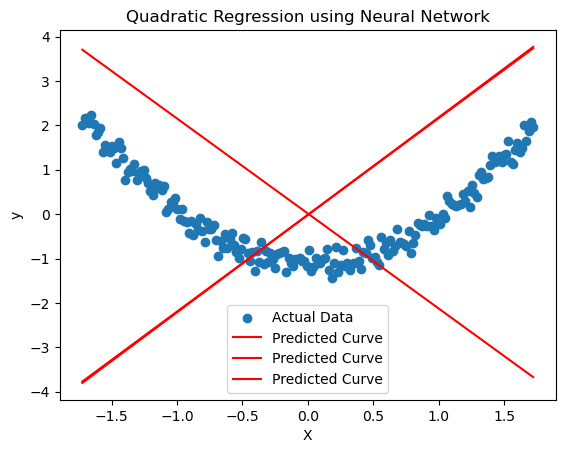

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Generate Quadratic Data
class GenerateQuadraticData:
    def __init__(self, n_points=200, a=1, b=-2, c=3, noise_std=5):
        """
        Generates quadratic data of the form y = ax^2 + bx + c + noise.
        :param n_points: Number of data points
        :param a: Coefficient of x^2
        :param b: Coefficient of x
        :param c: Constant term
        :param noise_std: Standard deviation of Gaussian noise
        """
        self.n_points = n_points
        self.a = a
        self.b = b
        self.c = c
        self.noise_std = noise_std

    def generate(self):
        x = np.linspace(-10, 10, self.n_points)
        noise = np.random.normal(0, self.noise_std, self.n_points)
        y = self.a * x**2 + self.b * x + self.c + noise
        return {"x": x, "y": y}

    def save_to_csv(self, file_name="quadratic_data.csv"):
        data = self.generate()
        df = pd.DataFrame(data)
        df.to_csv(file_name, index=False)
        print(f"Data saved to {file_name}.")

# Generate and save data
data_generator = GenerateQuadraticData(n_points=200, a=2, b=-1, c=3, noise_std=10)
data_generator.save_to_csv("quadratic_data.csv")

# Step 2: Load Data
def load_quadratic_data(file_name="quadratic_data.csv"):
    """
    Loads quadratic data from a CSV file.
    """
    data = pd.read_csv(file_name)
    print(f"Data loaded from {file_name}.")
    return data

data = load_quadratic_data()

# Prepare data
X = data["x"].values.reshape(-1, 1)
y = data["y"].values.reshape(-1, 1)

# Normalize for better training
X = (X - np.mean(X)) / np.std(X)
y = (y - np.mean(y)) / np.std(y)

# Step 3: Create and train Neural Network for regression
# Define Layer and Mean Squared Error Loss
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Loss_MeanSquaredError:
    def forward(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        self.dinputs = -2 * (y_true - dvalues) / samples

class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

# Build and train the model
dense1 = Layer_Dense(1, 64)
dense2 = Layer_Dense(64, 3)
dense3 = Layer_Dense(3, 1)

loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_Adam(learning_rate=0.01)

epochs = 1000
for epoch in range(epochs):
    dense1.forward(X)
    dense2.forward(dense1.output)
    dense3.forward(dense2.output)

    loss = loss_function.forward(dense3.output, y)

    loss_function.backward(dense3.output, y)


    dense3.backward(loss_function.dinputs)
    dense2.backward(dense3.dinputs)
    dense1.backward(dense2.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Save the model parameters
np.savez("quadratic_nn_model.npz", weights1=dense1.weights, biases1=dense1.biases, weights2=dense2.weights, biases2=dense2.biases)
print("Model saved as 'quadratic_nn_model.npz'.")


# Visualize results
plt.scatter(X, y, label="Actual Data")
plt.plot(X, dense2.output, color='r', label="Predicted Curve")
plt.title("Quadratic Regression using Neural Network")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()



Data saved to quadratic_data.csv.
Data loaded from quadratic_data.csv.
Epoch 0, Loss: 1.0000
Epoch 100, Loss: 0.0235
Epoch 200, Loss: 0.0225
Epoch 300, Loss: 0.0223
Epoch 400, Loss: 0.0219
Epoch 500, Loss: 0.0217
Epoch 600, Loss: 0.0215
Epoch 700, Loss: 0.0214
Epoch 800, Loss: 0.0213
Epoch 900, Loss: 0.0213
Model saved as 'quadratic_nn_model.npz'.


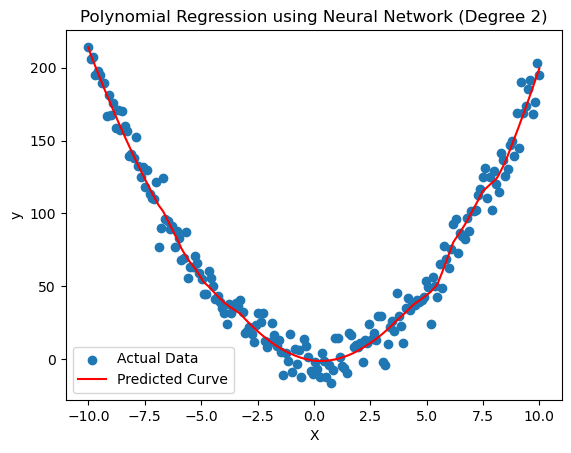

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Generate Quadratic Data
class GenerateQuadraticData:
    def __init__(self, n_points=200, a=1, b=-2, c=3, noise_std=5):
        """
        Generates quadratic data of the form y = ax^2 + bx + c + noise.
        :param n_points: Number of data points
        :param a: Coefficient of x^2
        :param b: Coefficient of x
        :param c: Constant term
        :param noise_std: Standard deviation of Gaussian noise
        """
        self.n_points = n_points
        self.a = a
        self.b = b
        self.c = c
        self.noise_std = noise_std

    def generate(self):
        x = np.linspace(-10, 10, self.n_points)
        noise = np.random.normal(0, self.noise_std, self.n_points)
        y = self.a * x**2 + self.b * x + self.c + noise
        return {"x": x, "y": y}

    def save_to_csv(self, file_name="quadratic_data.csv"):
        data = self.generate()
        df = pd.DataFrame(data)
        df.to_csv(file_name, index=False)
        print(f"Data saved to {file_name}.")

# Generate and save data
data_generator = GenerateQuadraticData(n_points=200, a=2, b=-1, c=3, noise_std=10)
data_generator.save_to_csv("quadratic_data.csv")

# Step 2: Load Data
def load_quadratic_data(file_name="quadratic_data.csv"):
    """
    Loads quadratic data from a CSV file.
    """
    data = pd.read_csv(file_name)
    print(f"Data loaded from {file_name}.")
    return data

data = load_quadratic_data()

# Prepare data
X = data["x"].values.reshape(-1, 1)
y = data["y"].values.reshape(-1, 1)

# Create polynomial features
degree = 2  # Adjust degree as needed for higher-degree data
def create_polynomial_features(X, degree):
    X_poly = X.copy()
    for d in range(2, degree + 1):
        X_poly = np.hstack((X_poly, X ** d))
    return X_poly

X_poly = create_polynomial_features(X, degree)

# Normalize for better training
X_mean = np.mean(X_poly, axis=0)
X_std = np.std(X_poly, axis=0)
X_poly = (X_poly - X_mean) / X_std

y_mean = np.mean(y)
y_std = np.std(y)
y = (y - y_mean) / y_std

# Step 3: Create and train Neural Network for regression
# Define Layer and Mean Squared Error Loss
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs  # Save inputs for backpropagation
        self.output = np.dot(inputs, self.weights) + self.biases  # Linear activation

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)  # Gradient on weights
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)  # Gradient on biases
        self.dinputs = np.dot(dvalues, self.weights.T)  # Gradient on inputs

class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs  # Save inputs for backpropagation
        self.output = np.maximum(0, inputs)  # ReLU activation

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()  # Initialize gradients
        self.dinputs[self.inputs <= 0] = 0  # Zero gradient where input is negative

class Loss_MeanSquaredError:
    def forward(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)  # Mean Squared Error

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        self.dinputs = -2 * (y_true - dvalues) / samples  # Gradient of MSE loss

class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            # Initialize momentums and caches
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentums with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # Correct bias for momentums
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        # Correct bias for cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Update weights and biases
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

# Build and train the model
input_dim = X_poly.shape[1]  # Adjust input dimension based on polynomial features

dense1 = Layer_Dense(input_dim, 64)
activation1 = Activation_ReLU()

dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()

dense3 = Layer_Dense(64, 1)  # Output layer

loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_Adam(learning_rate=0.01)

epochs = 1000
for epoch in range(epochs):
    # Forward pass
    dense1.forward(X_poly)
    activation1.forward(dense1.output)

    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    dense3.forward(activation2.output)
    y_pred = dense3.output

    # Calculate loss
    loss = loss_function.forward(y_pred, y)

    # Backward pass
    loss_function.backward(y_pred, y)
    dense3.backward(loss_function.dinputs)

    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)

    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Save the model parameters
np.savez("quadratic_nn_model.npz",
         weights1=dense1.weights, biases1=dense1.biases,
         weights2=dense2.weights, biases2=dense2.biases,
         weights3=dense3.weights, biases3=dense3.biases)
print("Model saved as 'quadratic_nn_model.npz'.")

# Visualize results
# Predict y for visualization
dense1.forward(X_poly)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
y_pred = dense3.output

# De-normalize data for plotting
X_original = X_poly * X_std + X_mean
y_pred_original = y_pred * y_std + y_mean
y_original = y * y_std + y_mean

# Sort values for a smooth curve
sorted_indices = X[:, 0].argsort()
X_sorted = X_original[sorted_indices]
y_pred_sorted = y_pred_original[sorted_indices]

plt.scatter(X_original[:, 0], y_original, label="Actual Data")
plt.plot(X_sorted[:, 0], y_pred_sorted, color='r', label="Predicted Curve")
plt.title(f"Polynomial Regression using Neural Network (Degree {degree})")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()
